## Data Loading

In [1]:
# Importing necessary libraries
import json
import pandas as pd
import requests
from io import BytesIO
from PIL import Image
import numpy as np
from IPython.display import display, HTML
import time
import concurrent.futures
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm.notebook import tqdm
!pip install ultralytics
from ultralytics import YOLO
import ast

#### Dataset import

In [2]:
combined_df = pd.read_csv('DEFINITIVOO.csv')

# Create the new feature based on the conditions
combined_df['special_feature'] = combined_df.apply(
    lambda row: 1 if (row['gender_author'] == 'male' and row['genre'] == 'romance') or
                      (row['gender_author'] == 'female' and row['genre'] == 'history') else 0,
    axis=1
)


/var/folders/_j/f96rrhbn7sn9rhplqnfbww180000gn/T/ipykernel_61351/2837139651.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.read_csv('DEFINITIVOO.csv')


In [3]:
combined_df.columns

Index(['book_id', 'ratings_count', 'authors', 'language_code', 'image_url',
       'author_id', 'name_author', 'ratings_count_authors', 'first_name',
       'gender_author', 'gender_probability', 'genre', 'brightness',
       'color_count', 'colorfulness', 'contrast', 'edge_density',
       'num_objects', 'class_counts', 'is_person', 'is_bird', 'is_clock',
       'is_cat', 'is_tv', 'saturation', 'Unnamed: 0', 'dominant_colors',
       'color_harmony', 'is_dog', 'is_cup', 'is_tie', 'special_feature',
       'log_ratings_count', 'brightness_x_special_feature',
       'saturation_x_special_feature', 'color_count_x_special_feature',
       'colorfulness_x_special_feature', 'contrast_x_special_feature',
       'edge_density_x_special_feature', 'num_objects_x_special_feature',
       'is_person_x_special_feature', 'is_bird_x_special_feature',
       'is_clock_x_special_feature', 'is_dog_x_special_feature',
       'is_cup_x_special_feature', 'is_tie_x_special_feature',
       'is_cat_x_specia

In [ ]:
import torch
import numpy as np
from sklearn.cluster import KMeans
from skimage import feature


# Define transformations
def compute_brightness(images):
    # Convert to grayscale
    images_gray = 0.2989 * images[:, 0, :, :] + 0.5870 * images[:, 1, :, :] + 0.1140 * images[:, 2, :, :]
    # Calculate mean pixel intensity for brightness
    brightness = images_gray.mean(dim=[1, 2])
    return brightness


def compute_color_count(images):
    # Downsample to speed up unique color count
    images = torch.nn.functional.interpolate(images, size=(50, 50), mode='bilinear')
    # Flatten pixel values for each image to find unique colors
    unique_colors_counts = []
    for img in images:
        unique_colors = torch.unique(img.view(3, -1).permute(1, 0), dim=0)
        unique_colors_counts.append(len(unique_colors))
    return torch.tensor(unique_colors_counts, device=images.device)

def get_dominant_colors_batch(images, k=4):
    # Reshape each image to a 2D array of pixels and apply K-Means clustering for each image in the batch
    dominant_colors = []
    images_np = images.permute(0, 2, 3, 1).cpu().numpy().reshape(len(images), -1, 3)  # Convert to (batch, pixels, 3)

    for img in images_np:
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        kmeans.fit(img)
        colors = kmeans.cluster_centers_.astype(int)
        dominant_colors.append(colors)

    # Convert the entire list to a single numpy array before converting to a tensor
    dominant_colors_np = np.array(dominant_colors)
    return torch.tensor(dominant_colors_np, device=images.device)

def compute_colorfulness(images):
    # Separate R, G, B channels
    R, G, B = images[:, 0, :, :], images[:, 1, :, :], images[:, 2, :, :]
    # Compute colorfulness metrics
    rg = torch.abs(R - G)
    yb = torch.abs(0.5 * (R + G) - B)
    colorfulness = torch.sqrt(rg.mean(dim=[1, 2]) ** 2 + yb.mean(dim=[1, 2]) ** 2)
    return colorfulness

def compute_contrast(images):
    # Convert images to grayscale
    images_gray = 0.2989 * images[:, 0, :, :] + 0.5870 * images[:, 1, :, :] + 0.1140 * images[:, 2, :, :]
    # Calculate standard deviation of pixel intensity for contrast
    contrast = images_gray.std(dim=[1, 2])
    return contrast

def compute_edge_density(images, sigma=1):
    # Convert to grayscale
    images_gray = 0.2989 * images[:, 0, :, :] + 0.5870 * images[:, 1, :, :] + 0.1140 * images[:, 2, :, :]
    images_gray = images_gray.cpu().numpy()  # Move to CPU for skimage processing

    edge_densities = []
    for img in images_gray:
        # Perform edge detection
        edges = feature.canny(img, sigma=sigma)
        # Calculate edge density
        edge_density = np.sum(edges) / edges.size
        edge_densities.append(edge_density)

    # Convert the list to a single numpy array and then to a tensor
    edge_densities_np = np.array(edge_densities)
    return torch.tensor(edge_densities_np, device=images.device)


import time

def extract_visual_features(image):
    brightness = compute_brightness(image)
    color_count = compute_color_count(image)
    colorfulness = compute_colorfulness(image)
    contrast = compute_contrast(image)
    edge_density = compute_edge_density(image)

    return {
        'brightness': brightness,
        'color_count': color_count,
        'colorfulness': colorfulness,
        'contrast': contrast,
        'edge_density': edge_density
    }

# Color Harmony Calculation
def calculate_color_harmony(dominant_colors_batch):
    harmony_values = []
    for dominant_colors in dominant_colors_batch:
        # Reshape dominant colors for pairwise distance calculation
        dominant_colors = dominant_colors.reshape(-1, 3)
        color_distances = []

        # Calculate pairwise distances between dominant colors
        for i in range(len(dominant_colors) - 1):
            for j in range(i + 1, len(dominant_colors)):
                dist = np.linalg.norm(dominant_colors[i] - dominant_colors[j])
                color_distances.append(dist)

        # Calculate color harmony as the standard deviation of color distances
        harmony = np.std(color_distances)
        harmony_values.append(harmony)

    return harmony_values

# Dominant Colors Extraction (Using KMeans)
def extract_dominant_colors(images, k=5):
    images_flat = images.view(images.shape[0], -1, 3).cpu().numpy()  # Reshape for clustering
    dominant_colors_batch = []
    for img_flat in images_flat:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(img_flat)
        dominant_colors_batch.append(kmeans.cluster_centers_.flatten())
    return np.array(dominant_colors_batch)

# Color Harmony Calculation
def calculate_color_harmony(dominant_colors_batch):
    harmony_values = []
    for dominant_colors in dominant_colors_batch:
        # Reshape dominant colors for pairwise distance calculation
        dominant_colors = dominant_colors.reshape(-1, 3)
        color_distances = []

        # Calculate pairwise distances between dominant colors
        for i in range(len(dominant_colors) - 1):
            for j in range(i + 1, len(dominant_colors)):
                dist = np.linalg.norm(dominant_colors[i] - dominant_colors[j])
                color_distances.append(dist)

        # Calculate color harmony as the standard deviation of color distances
        harmony = np.std(color_distances)
        harmony_values.append(harmony)

    return harmony_values

"import torch\nimport numpy as np\nfrom sklearn.cluster import KMeans\nfrom skimage import feature\n\n\n# Define transformations\ndef compute_brightness(images):\n    # Convert to grayscale\n    images_gray = 0.2989 * images[:, 0, :, :] + 0.5870 * images[:, 1, :, :] + 0.1140 * images[:, 2, :, :]\n    # Calculate mean pixel intensity for brightness\n    brightness = images_gray.mean(dim=[1, 2])\n    return brightness\n\n\ndef compute_color_count(images):\n    # Downsample to speed up unique color count\n    images = torch.nn.functional.interpolate(images, size=(50, 50), mode='bilinear')\n    # Flatten pixel values for each image to find unique colors\n    unique_colors_counts = []\n    for img in images:\n        unique_colors = torch.unique(img.view(3, -1).permute(1, 0), dim=0)\n        unique_colors_counts.append(len(unique_colors))\n    return torch.tensor(unique_colors_counts, device=images.device)\n\ndef get_dominant_colors_batch(images, k=4):\n    # Reshape each image to a 2D arra

In [ ]:
import requests
from PIL import Image
from torchvision import transforms
import torch
import numpy as np
from tqdm import tqdm 

# Define transformations for image processing
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to a consistent size
    transforms.ToTensor()  # Convert to tensor
])

def fetch_image(url):
    '''Fetch and preprocess an image from a URL.'''
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        img = Image.open(response.raw).convert('RGB')
        return image_transform(img)
    except Exception as e:
        print(f"Error fetching image from {url}: {e}")
        return None

def compute_saturation(images):
    '''Compute the average saturation of each image in a batch.'''
    images_np = images.permute(0, 2, 3, 1).cpu().numpy()  # Convert to (batch, H, W, C)
    saturations = []
    for img in images_np:
        pixels = img.reshape(-1, 3)  # Flatten to (pixels, 3)
        saturation = np.mean(
            (pixels.max(axis=1) - pixels.min(axis=1)) /
            (pixels.max(axis=1) + pixels.min(axis=1) + 1e-5)
        )
        saturations.append(saturation)
    return torch.tensor(saturations, device=images.device)

def extract_features_from_urls(df, image_url_column, batch_size=8):
   '''Extract features from a DataFrame containing image URLs with a progress bar.'''
    features = {
        'brightness': [],
        'color_count': [],
        'colorfulness': [],
        'contrast': [],
        'edge_density': [],
        'saturation': [],
        'dominant_colors': [],
        'color_harmony': []
    }
    
    images = []
    valid_indices = []

    # Initialize tqdm progress bar
    total = len(df)
    with tqdm(total=total, desc="Processing Images") as pbar:
        # Fetch and preprocess images
        for idx, url in enumerate(df[image_url_column]):
            image = fetch_image(url)
            if image is not None:
                images.append(image)
                valid_indices.append(idx)
            if len(images) == batch_size or (idx == len(df) - 1 and images):
                # Stack images into a batch
                image_batch = torch.stack(images).to('cuda' if torch.cuda.is_available() else 'cpu')
                
                # Extract features
                brightness = compute_brightness(image_batch)
                color_count = compute_color_count(image_batch)
                colorfulness = compute_colorfulness(image_batch)
                contrast = compute_contrast(image_batch)
                edge_density = compute_edge_density(image_batch)
                saturation = compute_saturation(image_batch)
                dominant_colors = get_dominant_colors_batch(image_batch, k=4).cpu().numpy()
                color_harmony = calculate_color_harmony(dominant_colors)

                # Store features
                features['brightness'].extend(brightness.cpu().tolist())
                features['color_count'].extend(color_count.cpu().tolist())
                features['colorfulness'].extend(colorfulness.cpu().tolist())
                features['contrast'].extend(contrast.cpu().tolist())
                features['edge_density'].extend(edge_density.cpu().tolist())
                features['saturation'].extend(saturation.cpu().tolist())
                features['dominant_colors'].extend(dominant_colors.tolist())
                features['color_harmony'].extend(color_harmony)

                # Reset images for the next batch
                images = []
            
            # Update progress bar
            pbar.update(1)

    # Create a new DataFrame with the extracted features
    feature_df = df.iloc[valid_indices].copy()
    for key, values in features.items():
        feature_df[key] = values
    
    return feature_df

processed_df = extract_features_from_urls(df, 'image_url')

'import requests\nfrom PIL import Image\nfrom torchvision import transforms\nimport torch\nimport numpy as np\nfrom tqdm import tqdm \n\n# Define transformations for image processing\nimage_transform = transforms.Compose([\n    transforms.Resize((224, 224)),  # Resize to a consistent size\n    transforms.ToTensor()  # Convert to tensor\n])\n\ndef fetch_image(url):\n    \'\'\'Fetch and preprocess an image from a URL.\'\'\'\n    try:\n        response = requests.get(url, stream=True)\n        response.raise_for_status()\n        img = Image.open(response.raw).convert(\'RGB\')\n        return image_transform(img)\n    except Exception as e:\n        print(f"Error fetching image from {url}: {e}")\n        return None\n\ndef compute_saturation(images):\n    \'\'\'Compute the average saturation of each image in a batch.\'\'\'\n    images_np = images.permute(0, 2, 3, 1).cpu().numpy()  # Convert to (batch, H, W, C)\n    saturations = []\n    for img in images_np:\n        pixels = img.reshape(

### OLS

In [6]:
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from IPython.display import HTML, display
import re  # For regex operations

model = smf.ols(
    formula='log_ratings_count ~ special_feature + brightness + saturation + color_count + colorfulness + contrast + edge_density + num_objects + is_person + is_bird + is_clock + is_dog + is_cup + is_tie + is_cat + is_tv',
    data=combined_df
    ).fit(cov_type='HC3')  # Using heteroskedasticity-consistent standard errors

model1 = smf.ols(
    formula='log_ratings_count ~ special_feature + genre_binary + brightness + saturation + color_count + colorfulness + contrast + edge_density + num_objects + is_person + is_bird + is_clock + is_dog + is_cup + is_tie + is_cat + is_tv',
    data=combined_df
    ).fit(cov_type='HC3')  # Using heteroskedasticity-consistent standard errors

model2 = smf.ols(
    formula='log_ratings_count ~ special_feature + genre_binary + ratings_count_authors + brightness + saturation + color_count + colorfulness + contrast + edge_density + num_objects + is_person + is_bird + is_clock + is_dog + is_cup + is_tie + is_cat + is_tv',
    data=combined_df
).fit(cov_type='HC3')

# Create a Stargazer object with the models
stargazer = Stargazer([model, model1, model2])

# Specify the desired order of covariates
stargazer.covariate_order([
    'special_feature', 'genre_binary', 'ratings_count_authors',
    'brightness', 'saturation', 'color_count', 'colorfulness',
    'contrast', 'edge_density', 'num_objects', 'is_person',
    'is_bird', 'is_clock', 'is_dog', 'is_cup', 'is_tie',
    'is_cat', 'is_tv'
])

# Customize the table
stargazer.title("OLS Regression Results")
stargazer.custom_columns(["Base Model", "Genre Control", "Genre and Author Success Control"], [1, 1, 1])


# Generate the HTML output
html_output = stargazer.render_html()

# Insert a unique ID into the table tag for targeted CSS
html_output = re.sub(r'<table>', '<table id="stargazer-table">', html_output, count=1)

# Define custom CSS to set the font to Times New Roman and style the table
custom_css = """
<style>
/* Apply Times New Roman to the Stargazer table only */
#stargazer-table {
    font-family: 'Times New Roman', Times, serif;
    font-size: 14px; /* Adjust font size as needed */
    width: 100%;
    border-collapse: collapse;
}

/* Style table headers */
#stargazer-table th {
    font-family: 'Times New Roman', Times, serif;
    background-color: #f2f2f2; /* Header background color */
    border: 1px solid #ddd; /* Header border */
    padding: 8px; /* Header padding */
    text-align: center; /* Header text alignment */
}

/* Style table data */
#stargazer-table td {
    font-family: 'Times New Roman', Times, serif;
    border: 1px solid #ddd; /* Data border */
    padding: 8px; /* Data padding */
    text-align: center; /* Data text alignment */
}
</style>
"""

# Combine CSS and HTML
styled_html = f"""
{custom_css}
{html_output}
"""

# Display the styled Stargazer table
display(HTML(styled_html))


In [7]:
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from IPython.display import HTML, display
import re  # For regex operations

# Define the models
model = smf.ols(
    formula='log_ratings_count ~ special_feature + brightness + saturation + color_count + colorfulness + contrast + edge_density + num_objects + is_person + is_bird + is_clock + is_dog + is_cup + is_tie + is_cat + is_tv',
    data=combined_df
).fit(cov_type='HC3')  # Using heteroskedasticity-consistent standard errors

model1 = smf.ols(
    formula='log_ratings_count ~ special_feature + genre_binary + brightness + saturation + color_count + colorfulness + contrast + edge_density + num_objects + is_person + is_bird + is_clock + is_dog + is_cup + is_tie + is_cat + is_tv',
    data=combined_df
).fit(cov_type='HC3')  # Using heteroskedasticity-consistent standard errors

model2 = smf.ols(
    formula='log_ratings_count ~ special_feature + genre_binary + ratings_count_authors + brightness + saturation + color_count + colorfulness + contrast + edge_density + num_objects + is_person + is_bird + is_clock + is_dog + is_cup + is_tie + is_cat + is_tv',
    data=combined_df
).fit(cov_type='HC3')

# Create a Stargazer object with the models
stargazer = Stargazer([model, model1, model2])

# Specify the covariates to display using original names
stargazer.covariate_order(['special_feature', 'genre_binary', 'ratings_count_authors'])

# Rename covariates for display
stargazer.rename_covariates({
    "special_feature": "Outsider",
    "genre_binary": "Genre",
    "ratings_count_authors": "Author Success"
})

# Rename the dependent variable
stargazer.dependent_variable_name("Log(Rating Count)")

# Customize the table
stargazer.title("OLS Regression Results")
stargazer.custom_columns(["Base Model", "Genre Control", "Genre and Author Success Control"], [1, 1, 1])

# Generate the HTML output
html_output = stargazer.render_html()

# Insert a unique ID into the table tag for targeted CSS
html_output = re.sub(r'<table>', '<table id="stargazer-table">', html_output, count=1)

# Define custom CSS to set the font to Times New Roman and style the table
custom_css = """
<style>
/* Apply Times New Roman to the Stargazer table only */
#stargazer-table {
    font-family: 'Times New Roman', Times, serif;
    font-size: 14px; /* Adjust font size as needed */
    width: 100%;
    border-collapse: collapse;
}

/* Style table headers */
#stargazer-table th {
    font-family: 'Times New Roman', Times, serif;
    background-color: #f2f2f2; /* Header background color */
    border: 1px solid #ddd; /* Header border */
    padding: 8px; /* Header padding */
    text-align: center; /* Header text alignment */
}

/* Style table data */
#stargazer-table td {
    font-family: 'Times New Roman', Times, serif;
    border: 1px solid #ddd; /* Data border */
    padding: 8px; /* Data padding */
    text-align: center; /* Data text alignment */
}
</style>
"""

# Combine CSS and HTML
styled_html = f"""
{custom_css}
{html_output}
"""

# Display the styled Stargazer table
display(HTML(styled_html))


##### Splitting samples

In [8]:
history_df = combined_df[combined_df['genre'] == 'history']
romance_df = combined_df[combined_df['genre'] == 'romance']

In [9]:
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from IPython.display import HTML, display
import re  # For regex operations

model_h = smf.ols(
    formula='log_ratings_count ~ special_feature + ratings_count_authors + brightness + saturation + color_count + colorfulness + contrast + edge_density + num_objects + is_person + is_bird + is_clock + is_dog + is_cup + is_tie + is_cat + is_tv',
    data=history_df
    ).fit(cov_type='HC3')  # Using heteroskedasticity-consistent standard errors

model_r = smf.ols(
    formula='log_ratings_count ~ special_feature + ratings_count_authors+ brightness + saturation + color_count + colorfulness + contrast + edge_density + num_objects + is_person + is_bird + is_clock + is_dog + is_cup + is_tie + is_cat + is_tv',
    data=romance_df
    ).fit(cov_type='HC3')  # Using heteroskedasticity-consistent standard errors

# Create a Stargazer object with the models
stargazer = Stargazer([model_h, model_r])

# Specify the desired order of covariates
stargazer.covariate_order([
    'special_feature', 'ratings_count_authors',
    'brightness', 'saturation', 'color_count', 'colorfulness',
    'contrast', 'edge_density', 'num_objects', 'is_person',
    'is_bird', 'is_clock', 'is_dog', 'is_cup', 'is_tie',
    'is_cat', 'is_tv'
])

# Customize the table
stargazer.title("OLS Regression Results")
stargazer.custom_columns(["History", "Romance"], [1, 1])


# Generate the HTML output
html_output = stargazer.render_html()

# Insert a unique ID into the table tag for targeted CSS
html_output = re.sub(r'<table>', '<table id="stargazer-table">', html_output, count=1)

# Define custom CSS to set the font to Times New Roman and style the table
custom_css = """
<style>
/* Apply Times New Roman to the Stargazer table only */
#stargazer-table {
    font-family: 'Times New Roman', Times, serif;
    font-size: 14px; /* Adjust font size as needed */
    width: 100%;
    border-collapse: collapse;
}

/* Style table headers */
#stargazer-table th {
    font-family: 'Times New Roman', Times, serif;
    background-color: #f2f2f2; /* Header background color */
    border: 1px solid #ddd; /* Header border */
    padding: 8px; /* Header padding */
    text-align: center; /* Header text alignment */
}

/* Style table data */
#stargazer-table td {
    font-family: 'Times New Roman', Times, serif;
    border: 1px solid #ddd; /* Data border */
    padding: 8px; /* Data padding */
    text-align: center; /* Data text alignment */
}
</style>
"""

# Combine CSS and HTML
styled_html = f"""
{custom_css}
{html_output}
"""

# Display the styled Stargazer table
display(HTML(styled_html))


/Users/nico/anaconda3/envs/tesi/lib/python3.9/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 17, but rank is 14
  warnings.warn('covariance of constraints does not have full '
/Users/nico/anaconda3/envs/tesi/lib/python3.9/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 17, but rank is 14
  warnings.warn('covariance of constraints does not have full '


In [10]:
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from IPython.display import HTML, display
import re  # For regex operations

# Define the models
model_h = smf.ols(
    formula='log_ratings_count ~ special_feature + ratings_count_authors + brightness + saturation + color_count + colorfulness + contrast + edge_density + num_objects + is_person + is_bird + is_clock + is_dog + is_cup + is_tie + is_cat + is_tv',
    data=history_df
).fit(cov_type='HC3')  # Using heteroskedasticity-consistent standard errors

model_r = smf.ols(
    formula='log_ratings_count ~ special_feature + ratings_count_authors + brightness + saturation + color_count + colorfulness + contrast + edge_density + num_objects + is_person + is_bird + is_clock + is_dog + is_cup + is_tie + is_cat + is_tv',
    data=romance_df
).fit(cov_type='HC3')

# Create a Stargazer object with the models
stargazer = Stargazer([model_h, model_r])

# Specify the covariates to display
stargazer.covariate_order(['special_feature', 'ratings_count_authors'])

# Rename the dependent variable to 'logarithmic count of ratings'
stargazer.dependent_variable_name("logarithmic count of ratings")

# Customize the table
stargazer.title("OLS Regression Results")
stargazer.custom_columns(["History", "Romance"], [1, 1])

# Generate the HTML output
html_output = stargazer.render_html()

# Insert a unique ID into the table tag for targeted CSS
html_output = re.sub(r'<table>', '<table id="stargazer-table">', html_output, count=1)

# Define custom CSS to set the font to Times New Roman and style the table
custom_css = """
<style>
/* Apply Times New Roman to the Stargazer table only */
#stargazer-table {
    font-family: 'Times New Roman', Times, serif;
    font-size: 14px; /* Adjust font size as needed */
    width: 100%;
    border-collapse: collapse;
}

/* Style table headers */
#stargazer-table th {
    font-family: 'Times New Roman', Times, serif;
    background-color: #f2f2f2; /* Header background color */
    border: 1px solid #ddd; /* Header border */
    padding: 8px; /* Header padding */
    text-align: center; /* Header text alignment */
}

/* Style table data */
#stargazer-table td {
    font-family: 'Times New Roman', Times, serif;
    border: 1px solid #ddd; /* Data border */
    padding: 8px; /* Data padding */
    text-align: center; /* Data text alignment */
}
</style>
"""

# Combine CSS and HTML
styled_html = f"""
{custom_css}
{html_output}
"""

# Display the styled Stargazer table
display(HTML(styled_html))


/Users/nico/anaconda3/envs/tesi/lib/python3.9/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 17, but rank is 14
  warnings.warn('covariance of constraints does not have full '
/Users/nico/anaconda3/envs/tesi/lib/python3.9/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 17, but rank is 14
  warnings.warn('covariance of constraints does not have full '


## Random Forest


In [11]:
# Define the feature set (including interaction terms) and target variable
X = combined_df[['brightness', 'saturation', 'color_count', 'colorfulness', 'contrast', 'edge_density', 'special_feature', 'num_objects', 'is_person', 'is_bird', 'is_clock','is_dog', 'is_cup', 'is_tie',
       'is_cat', 'is_tv',
                 'brightness_x_special_feature', 'colorfulness_x_special_feature',
                 'contrast_x_special_feature', 'edge_density_x_special_feature', 'saturation_x_special_feature', 'color_count_x_special_feature',
                 'is_person_x_special_feature', 'is_bird_x_special_feature', 'is_clock_x_special_feature', 'is_dog_x_special_feature', 'is_cup_x_special_feature', 'is_tie_x_special_feature', 'is_cat_x_special_feature', 'is_tv_x_special_feature', 'num_objects_x_special_feature']]
y = combined_df['log_ratings_count']

In [12]:
"""from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 500],          # Number of trees in the forest
    'max_depth': [10, 20, 30, None],         # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],         # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],           # Minimum samples required at each leaf node
    'max_features': ['auto', 'sqrt', 'log2'] # Number of features to consider when looking for the best split
}

# Set up the GridSearchCV with 'r2' as the scoring metric
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='r2',  # Use built-in R-squared scoring
    cv=5,          # 5-fold cross-validation
    verbose=2,     # Higher verbosity for detailed output
    n_jobs=-2      # Use all available cores for parallel computation
)

# Perform the grid search
grid_search.fit(X, y)

# Get the best hyperparameters and the corresponding score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best R-squared Score:", grid_search.best_score_)"""


'from sklearn.ensemble import RandomForestRegressor\nfrom sklearn.model_selection import GridSearchCV\n\n# Define the Random Forest Regressor\nrf = RandomForestRegressor(random_state=42)\n\n# Define the hyperparameter grid\nparam_grid = {\n    \'n_estimators\': [100, 200, 500],          # Number of trees in the forest\n    \'max_depth\': [10, 20, 30, None],         # Maximum depth of the tree\n    \'min_samples_split\': [2, 5, 10],         # Minimum samples required to split a node\n    \'min_samples_leaf\': [1, 2, 4],           # Minimum samples required at each leaf node\n    \'max_features\': [\'auto\', \'sqrt\', \'log2\'] # Number of features to consider when looking for the best split\n}\n\n# Set up the GridSearchCV with \'r2\' as the scoring metric\ngrid_search = GridSearchCV(\n    estimator=rf,\n    param_grid=param_grid,\n    scoring=\'r2\',  # Use built-in R-squared scoring\n    cv=5,          # 5-fold cross-validation\n    verbose=2,     # Higher verbosity for detailed output

In [13]:
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest with the best hyperparameters
rf_combined = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42
)

# Fit the model
rf_combined.fit(X, y)


RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=4,
                      n_estimators=200, random_state=42)

In [14]:
from sklearn.metrics import r2_score, mean_absolute_error

# Predictions
y_pred = rf_combined.predict(X)

# Evaluation metrics
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print(f"R-squared: {r2:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")


R-squared: 0.029
Mean Absolute Error: 1.498


In [15]:
""""from sklearn.inspection import permutation_importance

# Compute permutation importance
perm_importance = permutation_importance(rf_combined, X, y, n_repeats=30, random_state=42)

# Display importance and p-values
for feature, importance, pval in zip(X.columns, perm_importance.importances_mean, perm_importance.importances_std):
    print(f"Feature: {feature}, Importance: {importance:.4f}, Std Dev: {pval:.4f}")"""

'"from sklearn.inspection import permutation_importance\n\n# Compute permutation importance\nperm_importance = permutation_importance(rf_combined, X, y, n_repeats=30, random_state=42)\n\n# Display importance and p-values\nfor feature, importance, pval in zip(X.columns, perm_importance.importances_mean, perm_importance.importances_std):\n    print(f"Feature: {feature}, Importance: {importance:.4f}, Std Dev: {pval:.4f}")'

In [16]:
"""from sklearn.inspection import permutation_importance
from scipy.stats import ttest_rel, wilcoxon
import pandas as pd

# Fit your model (e.g., Random Forest or Gradient Boosting)
rf_combined.fit(X, y)

# Compute permutation importance for all features
perm_importance = permutation_importance(rf_combined, X, y, n_repeats=30, random_state=42)

# Extract importance values for each feature
importance_dict = {feature: perm_importance.importances[i] for i, feature in enumerate(X.columns)}

# Convert to a DataFrame for easier manipulation
importance_df = pd.DataFrame(importance_dict)

# Example: Compare all main effects with their corresponding interaction terms
results = []
for feature in ['brightness', 'saturation', 'color_count', 'colorfulness', 'contrast', 'edge_density', 'num_objects', 'is_person', 'is_bird', 'is_clock','is_dog', 'is_cup', 'is_tie',
       'is_cat', 'is_tv']:
    interaction_feature = f"{feature}_x_special_feature"

    if interaction_feature in importance_df.columns:
        # Extract distributions
        main_effect_importances = importance_df[feature]
        interaction_importances = importance_df[interaction_feature]

        # Perform paired t-test
        t_stat, p_value_ttest = ttest_rel(main_effect_importances, interaction_importances)

        # Perform Wilcoxon signed-rank test (non-parametric alternative)
        w_stat, p_value_wilcoxon = wilcoxon(main_effect_importances, interaction_importances)

        # Store the results
        results.append({
            'Feature': feature,
            'Interaction': interaction_feature,
            'Mean_Main_Effect': main_effect_importances.mean(),
            'Mean_Interaction': interaction_importances.mean(),
            'T-Stat': t_stat,
            'P-Value (t-test)': p_value_ttest,
            'W-Stat': w_stat,
            'P-Value (Wilcoxon)': p_value_wilcoxon
        })

# Convert results to a DataFrame for display
results_df = pd.DataFrame(results)

# Display results
display(name="Statistical Test Results for Feature Importances", dataframe=results_df)
"""

'from sklearn.inspection import permutation_importance\nfrom scipy.stats import ttest_rel, wilcoxon\nimport pandas as pd\n\n# Fit your model (e.g., Random Forest or Gradient Boosting)\nrf_combined.fit(X, y)\n\n# Compute permutation importance for all features\nperm_importance = permutation_importance(rf_combined, X, y, n_repeats=30, random_state=42)\n\n# Extract importance values for each feature\nimportance_dict = {feature: perm_importance.importances[i] for i, feature in enumerate(X.columns)}\n\n# Convert to a DataFrame for easier manipulation\nimportance_df = pd.DataFrame(importance_dict)\n\n# Example: Compare all main effects with their corresponding interaction terms\nresults = []\nfor feature in [\'brightness\', \'saturation\', \'color_count\', \'colorfulness\', \'contrast\', \'edge_density\', \'num_objects\', \'is_person\', \'is_bird\', \'is_clock\',\'is_dog\', \'is_cup\', \'is_tie\',\n       \'is_cat\', \'is_tv\']:\n    interaction_feature = f"{feature}_x_special_feature"\n\n  

In [17]:
"""import seaborn as sns
import matplotlib.pyplot as plt

for feature in ['brightness', 'saturation', 'color_count', 'colorfulness', 'contrast', 'edge_density', 'num_objects', 'is_person', 'is_bird', 'is_clock','is_dog', 'is_cup', 'is_tie',
       'is_cat', 'is_tv']:
    interaction_feature = f"{feature}_x_special_feature"

    if interaction_feature in importance_df.columns:
        plt.figure(figsize=(8, 6))
        sns.kdeplot(importance_df[feature], label=feature, shade=True)
        sns.kdeplot(importance_df[interaction_feature], label=interaction_feature, shade=True)
        plt.title(f'Permutation Importances: {feature} vs {interaction_feature}')
        plt.xlabel('Importance')
        plt.ylabel('Density')
        plt.legend()
        plt.show()"""


'import seaborn as sns\nimport matplotlib.pyplot as plt\n\nfor feature in [\'brightness\', \'saturation\', \'color_count\', \'colorfulness\', \'contrast\', \'edge_density\', \'num_objects\', \'is_person\', \'is_bird\', \'is_clock\',\'is_dog\', \'is_cup\', \'is_tie\',\n       \'is_cat\', \'is_tv\']:\n    interaction_feature = f"{feature}_x_special_feature"\n\n    if interaction_feature in importance_df.columns:\n        plt.figure(figsize=(8, 6))\n        sns.kdeplot(importance_df[feature], label=feature, shade=True)\n        sns.kdeplot(importance_df[interaction_feature], label=interaction_feature, shade=True)\n        plt.title(f\'Permutation Importances: {feature} vs {interaction_feature}\')\n        plt.xlabel(\'Importance\')\n        plt.ylabel(\'Density\')\n        plt.legend()\n        plt.show()'

In [18]:
"""from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import numpy as np

# Define the features to plot and their interactions
features = [
    ('colorfulness', 'colorfulness_x_special_feature'),
    ('brightness', 'brightness_x_special_feature'),
    ('saturation', 'saturation_x_special_feature'),
    ('color_count', 'color_count_x_special_feature'),
    ('edge_density', 'edge_density_x_special_feature'),
    ('contrast', 'contrast_x_special_feature'),
    ('num_objects', 'num_objects_x_special_feature'),
]

# Initialize variables to track min and max y values
min_y, max_y = np.inf, -np.inf

# First pass: Determine global min and max y-axis limits
for feature_pair in features:
    fig, ax = plt.subplots()  # Create a temporary figure for consistent scaling
    pdp = PartialDependenceDisplay.from_estimator(rf_combined, X, feature_pair, ax=ax)
    for single_ax in pdp.axes_.flatten():  # Iterate over all axes in the plot
        ylim = single_ax.get_ylim()
        min_y = min(min_y, ylim[0])
        max_y = max(max_y, ylim[1])
    plt.close(fig)  # Close temporary plots

# Second pass: Plot with consistent y-axis limits
fig, axes = plt.subplots(len(features), 1, figsize=(8, len(features) * 4))

for ax, feature_pair in zip(axes, features):
    pdp = PartialDependenceDisplay.from_estimator(
        rf_combined, X, feature_pair, ax=ax
    )
    ax.set_title(f'PDP for {feature_pair[0]} and {feature_pair[1]}')
    ax.set_ylim(min_y, max_y)  # Apply consistent y-axis limits

plt.tight_layout()
plt.show()
"""

"from sklearn.inspection import PartialDependenceDisplay\nimport matplotlib.pyplot as plt\nimport numpy as np\n\n# Define the features to plot and their interactions\nfeatures = [\n    ('colorfulness', 'colorfulness_x_special_feature'),\n    ('brightness', 'brightness_x_special_feature'),\n    ('saturation', 'saturation_x_special_feature'),\n    ('color_count', 'color_count_x_special_feature'),\n    ('edge_density', 'edge_density_x_special_feature'),\n    ('contrast', 'contrast_x_special_feature'),\n    ('num_objects', 'num_objects_x_special_feature'),\n]\n\n# Initialize variables to track min and max y values\nmin_y, max_y = np.inf, -np.inf\n\n# First pass: Determine global min and max y-axis limits\nfor feature_pair in features:\n    fig, ax = plt.subplots()  # Create a temporary figure for consistent scaling\n    pdp = PartialDependenceDisplay.from_estimator(rf_combined, X, feature_pair, ax=ax)\n    for single_ax in pdp.axes_.flatten():  # Iterate over all axes in the plot\n        

### Splitting Samples 

#### History

In [52]:
history_df = combined_df[combined_df['genre'] == 'history']
romance_df = combined_df[combined_df['genre'] == 'romance']

In [53]:
history_df[['gender_author']].value_counts()

gender_author
male             20372
female           15244
Name: count, dtype: int64

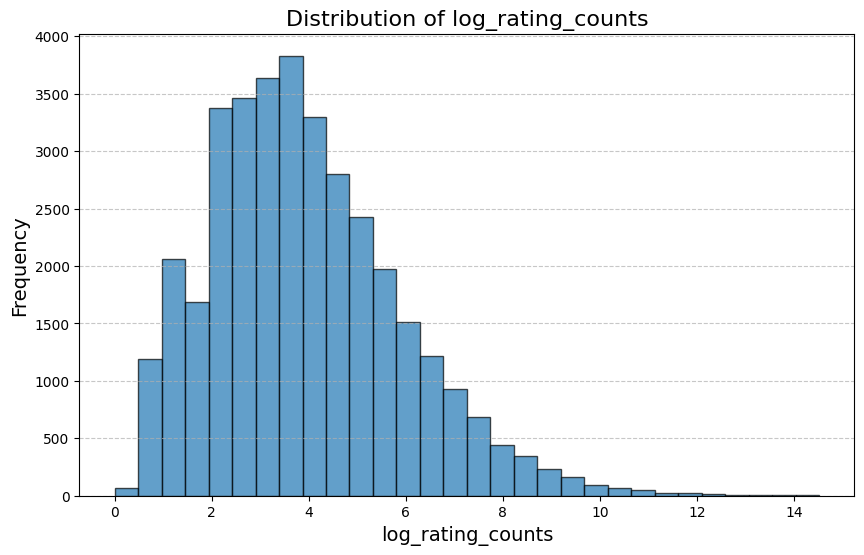

In [54]:
import matplotlib.pyplot as plt

# Plot the distribution of log_rating_counts
plt.figure(figsize=(10, 6))
plt.hist(history_df['log_ratings_count'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of log_rating_counts', fontsize=16)
plt.xlabel('log_rating_counts', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Filter rows where gender_author == 'male'
male_df = history_df[history_df['gender_author'] == 'male']

# Create bins for stratified sampling (e.g., 10 bins, adjust as needed)
male_df['log_ratings_count_bin'] = pd.qcut(male_df['log_ratings_count'], q=10, duplicates='drop')

# Perform stratified sampling to SELECT 5128 rows to drop
male_to_drop, _ = train_test_split(
    male_df,
    test_size=(len(male_df) - 5128) / len(male_df),
    stratify=male_df['log_ratings_count_bin'],
    random_state=42
)

# Drop the sampled rows from the original dataframe
history_df = history_df.drop(index=male_to_drop.index)

# Clean up the temporary column if it exists
history_df = history_df.drop(columns=['log_ratings_count_bin'], errors='ignore')

print(f"New dataframe shape: {history_df.shape}")


New dataframe shape: (30488, 49)


/var/folders/_j/f96rrhbn7sn9rhplqnfbww180000gn/T/ipykernel_61351/1046015504.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_df['log_ratings_count_bin'] = pd.qcut(male_df['log_ratings_count'], q=10, duplicates='drop')


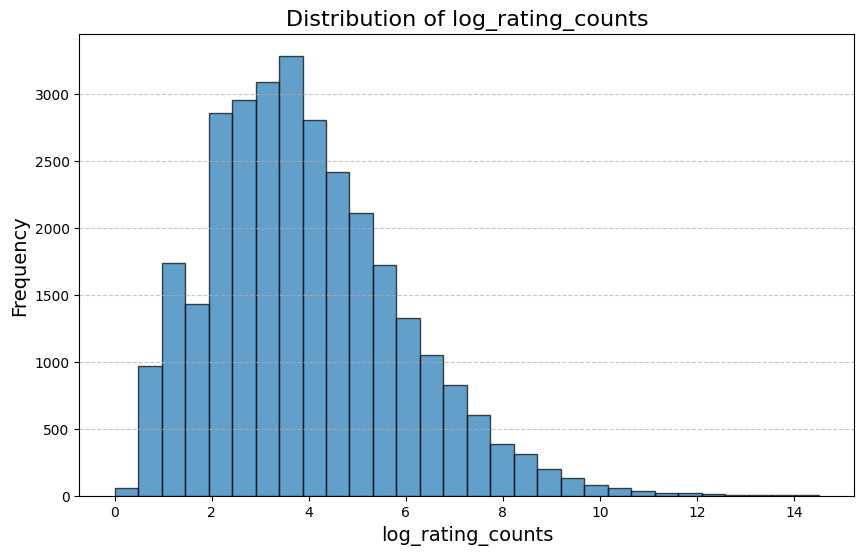

In [56]:
import matplotlib.pyplot as plt

# Plot the distribution of log_rating_counts
plt.figure(figsize=(10, 6))
plt.hist(history_df['log_ratings_count'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of log_rating_counts', fontsize=16)
plt.xlabel('log_rating_counts', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [57]:
history_df[['gender_author']].value_counts()

gender_author
female           15244
male             15244
Name: count, dtype: int64

In [58]:
romance_df[['gender_author']].value_counts()

gender_author
female           77893
male              5540
Name: count, dtype: int64

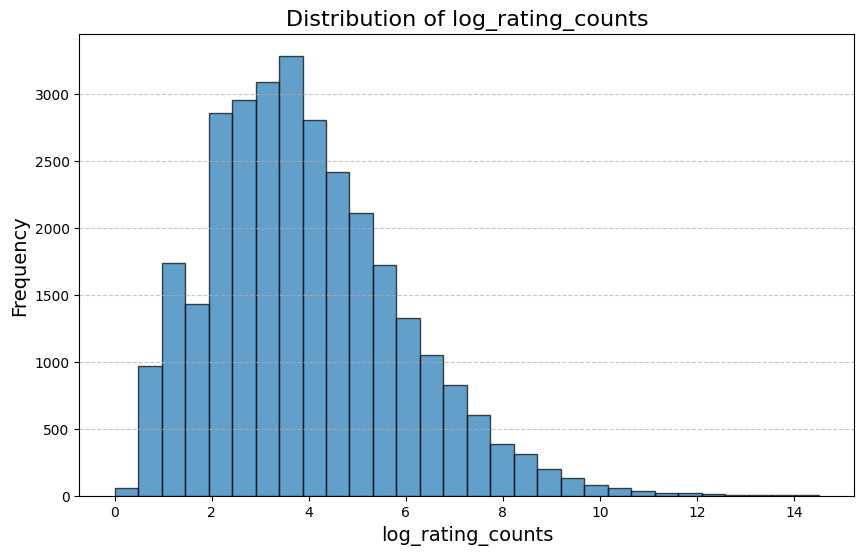

In [59]:
import matplotlib.pyplot as plt

# Plot the distribution of log_rating_counts
plt.figure(figsize=(10, 6))
plt.hist(history_df['log_ratings_count'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of log_rating_counts', fontsize=16)
plt.xlabel('log_rating_counts', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Filter rows where gender_author == 'male'
female_df = romance_df[romance_df['gender_author'] == 'female']

# Create bins for stratified sampling (e.g., 10 bins, adjust as needed)
female_df['log_ratings_count_bin'] = pd.qcut(female_df['log_ratings_count'], q=10, duplicates='drop')

# Perform stratified sampling to SELECT 5128 rows to drop
male_to_drop, _ = train_test_split(
    female_df,
    test_size=(len(female_df) - 72353) / len(female_df),
    stratify=female_df['log_ratings_count_bin'],
    random_state=42
)

# Drop the sampled rows from the original dataframe
romance_df = romance_df.drop(index=male_to_drop.index)

# Clean up the temporary column if it exists
romance_df = romance_df.drop(columns=['log_ratings_count_bin'], errors='ignore')

print(f"New dataframe shape: {romance_df.shape}")


/var/folders/_j/f96rrhbn7sn9rhplqnfbww180000gn/T/ipykernel_61351/1192442274.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  female_df['log_ratings_count_bin'] = pd.qcut(female_df['log_ratings_count'], q=10, duplicates='drop')


New dataframe shape: (11080, 49)


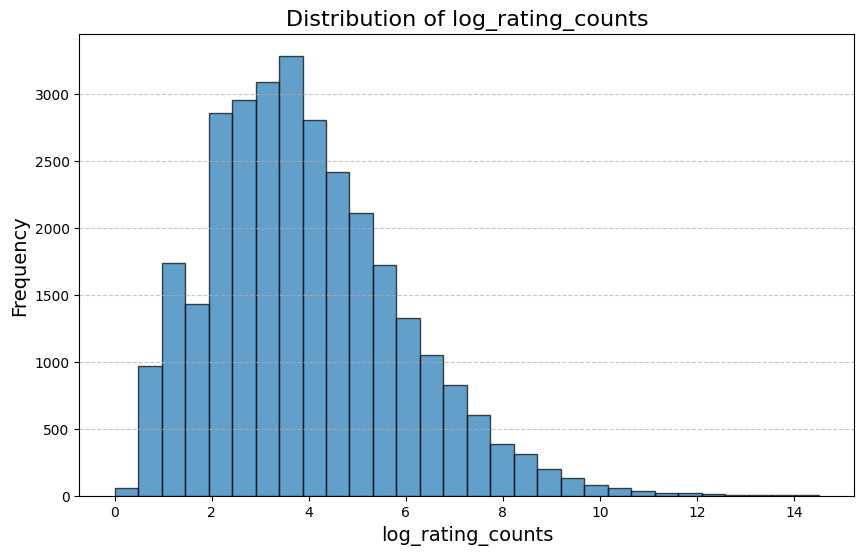

In [61]:
import matplotlib.pyplot as plt

# Plot the distribution of log_rating_counts
plt.figure(figsize=(10, 6))
plt.hist(history_df['log_ratings_count'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of log_rating_counts', fontsize=16)
plt.xlabel('log_rating_counts', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [62]:
romance_df[['gender_author']].value_counts()

gender_author
female           5540
male             5540
Name: count, dtype: int64

In [63]:
# Creating 'is_insider' and 'is_outsider' columns based on 'gender_author'
history_df['is_insider'] = history_df['gender_author'].apply(lambda x: 1 if x == 'male' else 0)
history_df['is_outsider'] = history_df['gender_author'].apply(lambda x: 1 if x == 'female' else 0)

In [64]:
# Creating 'is_insider' and 'is_outsider' columns based on 'gender_author'
romance_df['is_insider'] = romance_df['gender_author'].apply(lambda x: 1 if x == 'female' else 0)
romance_df['is_outsider'] = romance_df['gender_author'].apply(lambda x: 1 if x == 'male' else 0)

In [65]:
# Create interaction terms for features
for col in ['brightness', 'saturation', 'color_count', 'colorfulness', 'contrast', 'edge_density', 'num_objects', 'is_person', 'is_bird', 'is_clock','is_dog', 'is_cup', 'is_tie',
       'is_cat', 'is_tv']:
    history_df[f"{col}_x_is_insider"] = history_df[col] * history_df['is_insider']

# Create interaction terms for features
for col in ['brightness', 'saturation', 'color_count', 'colorfulness', 'contrast', 'edge_density', 'num_objects', 'is_person', 'is_bird', 'is_clock','is_dog', 'is_cup', 'is_tie',
       'is_cat', 'is_tv']:
    history_df[f"{col}_x_is_outsider"] = history_df[col] * history_df['is_outsider']

# Define the feature set (including interaction terms) and target variable
X = history_df[['brightness_x_is_insider', 'saturation_x_is_insider', 'color_count_x_is_insider', 'colorfulness_x_is_insider', 'contrast_x_is_insider', 'edge_density_x_is_insider', 'num_objects_x_is_insider', 'is_person_x_is_insider', 'is_bird_x_is_insider', 'is_clock_x_is_insider','is_dog_x_is_insider', 'is_cup_x_is_insider', 'is_tie_x_is_insider',
         'is_cat_x_is_insider', 'is_tv_x_is_insider',
                    'brightness_x_is_outsider', 'saturation_x_is_outsider', 'color_count_x_is_outsider', 'colorfulness_x_is_outsider', 'contrast_x_is_outsider', 'edge_density_x_is_outsider', 'num_objects_x_is_outsider', 'is_person_x_is_outsider', 'is_bird_x_is_outsider', 'is_clock_x_is_outsider','is_dog_x_is_outsider', 'is_cup_x_is_outsider', 'is_tie_x_is_outsider',
            'is_cat_x_is_outsider', 'is_tv_x_is_outsider']]
y = history_df['log_ratings_count']

# Train a Random Forest with the best hyperparameters
rf_combined = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42
)

# Fit the model
rf_combined.fit(X, y)

# Predictions
y_pred = rf_combined.predict(X)

# Evaluation metrics
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print(f"R-squared: {r2:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")


R-squared: 0.067
Mean Absolute Error: 1.496


In [66]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
perm_importance = permutation_importance(rf_combined, X, y, n_repeats=30, random_state=42)

# Display importance and p-values
for feature, importance, pval in zip(X.columns, perm_importance.importances_mean, perm_importance.importances_std):
    print(f"Feature: {feature}, Importance: {importance:.4f}, Std Dev: {pval:.4f}")

Feature: brightness_x_is_insider, Importance: 0.0243, Std Dev: 0.0006
Feature: saturation_x_is_insider, Importance: 0.0122, Std Dev: 0.0003
Feature: color_count_x_is_insider, Importance: 0.0115, Std Dev: 0.0002
Feature: colorfulness_x_is_insider, Importance: 0.0109, Std Dev: 0.0004
Feature: contrast_x_is_insider, Importance: 0.0234, Std Dev: 0.0008
Feature: edge_density_x_is_insider, Importance: 0.0401, Std Dev: 0.0014
Feature: num_objects_x_is_insider, Importance: 0.0036, Std Dev: 0.0001
Feature: is_person_x_is_insider, Importance: 0.0034, Std Dev: 0.0001
Feature: is_bird_x_is_insider, Importance: 0.0009, Std Dev: 0.0000
Feature: is_clock_x_is_insider, Importance: 0.0012, Std Dev: 0.0000
Feature: is_dog_x_is_insider, Importance: 0.0000, Std Dev: 0.0000
Feature: is_cup_x_is_insider, Importance: 0.0000, Std Dev: 0.0000
Feature: is_tie_x_is_insider, Importance: 0.0000, Std Dev: 0.0000
Feature: is_cat_x_is_insider, Importance: 0.0005, Std Dev: 0.0000
Feature: is_tv_x_is_insider, Importanc

In [67]:
from sklearn.inspection import permutation_importance
from scipy.stats import ttest_rel, wilcoxon
import pandas as pd

# Fit your model (e.g., Random Forest or Gradient Boosting)
rf_combined.fit(X, y)

# Compute permutation importance for all features
perm_importance = permutation_importance(rf_combined, X, y, n_repeats=30, random_state=42)

# Extract importance values for each feature
importance_dict = {feature: perm_importance.importances[i] for i, feature in enumerate(X.columns)}

# Convert to a DataFrame for easier manipulation
importance_df = pd.DataFrame(importance_dict)

# Example: Compare interaction terms for insider vs outsider
results = []
for feature in ['brightness', 'saturation', 'color_count', 'colorfulness', 'contrast', 'edge_density', 'num_objects', 'is_person', 'is_bird', 'is_clock', 'is_dog', 'is_cup', 'is_tie',
       'is_cat', 'is_tv']:
    insider_feature = f"{feature}_x_is_insider"
    outsider_feature = f"{feature}_x_is_outsider"

    if insider_feature in importance_df.columns and outsider_feature in importance_df.columns:
        # Extract distributions
        insider_importances = importance_df[insider_feature]
        outsider_importances = importance_df[outsider_feature]

        # Perform paired t-test
        t_stat, p_value_ttest = ttest_rel(insider_importances, outsider_importances)

        # Perform Wilcoxon signed-rank test (non-parametric alternative)
        try:
            w_stat, p_value_wilcoxon = wilcoxon(insider_importances, outsider_importances, zero_method="zsplit")
        except ValueError:
            w_stat, p_value_wilcoxon = None, None  # Handle case with all-zero differences

        # Store the results
        results.append({
            'Feature': feature,
            'Insider Interaction': insider_feature,
            'Outsider Interaction': outsider_feature,
            'Mean_Insider': insider_importances.mean(),
            'Mean_Outsider': outsider_importances.mean(),
            'T-Stat': t_stat,
            'P-Value (t-test)': p_value_ttest,
            'W-Stat': w_stat,
            'P-Value (Wilcoxon)': p_value_wilcoxon
        })

# Convert results to a DataFrame for display
results_df = pd.DataFrame(results)

In [68]:
# Function to clean and transform feature names
def clean_feature_name(feature_name):
    if feature_name == "edge_density":
        return "Edge density"
    elif feature_name == "num_objects":
        return "Number of Objects"
    elif "is_" in feature_name:  # Remove 'is_' and capitalize
        return feature_name.replace("is_", "").capitalize()
    else:
        return feature_name.capitalize()

# Apply the transformations to 'Feature', 'Insider Interaction', and 'Outsider Interaction'
results_df['Feature'] = results_df['Feature'].apply(clean_feature_name)

# Drop the Insider and Outsider Interaction columns
results_df.drop(columns=['Insider Interaction', 'Outsider Interaction'], inplace=True)

# Rename the columns 'Mean_Insider' and 'Mean_Outsider'
results_df.rename(columns={
    'Mean_Insider': 'Mean Value Insider',
    'Mean_Outsider': 'Mean Value Outsider'
}, inplace=True)


In [69]:
from IPython.display import display, HTML
import pandas as pd

# Convert the DataFrame to HTML
html_table = results_df.to_html(index=False)

# Define custom CSS to style the table
custom_css = """
<style>
/* Apply Times New Roman to the table */
table {
    font-family: 'Times New Roman', Times, serif;
    font-size: 14px; /* Adjust font size */
    width: 100%;
    border-collapse: collapse;
    text-align: center;
}

/* Style table headers */
table th {
    background-color: #f2f2f2; /* Header background color */
    border: 1px solid #ddd; /* Header border */
    padding: 8px; /* Header padding */
}

/* Style table data */
table td {
    border: 1px solid #ddd; /* Data border */
    padding: 8px; /* Data padding */
}
</style>
"""

# Combine the CSS and HTML table
styled_table = f"{custom_css}\n{html_table}"

# Save the styled table to an HTML file
output_file = "styled_table.html"
with open(output_file, "w") as file:
    file.write(styled_table)

# Display the styled table
display(HTML(styled_table))


Feature,Mean Value Insider,Mean Value Outsider,T-Stat,P-Value (t-test),W-Stat,P-Value (Wilcoxon)
Brightness,0.024278,0.017888,35.879540,1.397807e-25,0.0,1.862645e-09
Saturation,0.012196,0.013030,-11.188177,4.870922e-12,0.0,1.862645e-09
Color_count,0.011468,0.019472,-72.596973,2.353373e-34,0.0,1.862645e-09
Colorfulness,0.010918,0.013937,-35.786409,1.504808e-25,0.0,1.862645e-09
Contrast,0.023411,0.026784,-15.652344,1.114626e-15,0.0,1.862645e-09
Edge density,0.040114,0.026014,59.877798,6.052931e-32,0.0,1.862645e-09
Number of Objects,0.003604,0.003906,-15.453924,1.552948e-15,0.0,1.862645e-09
Person,0.003410,0.003328,2.708813,1.121113e-02,119.0,1.852948e-02
Bird,0.000893,0.000968,-6.858609,1.558235e-07,16.0,3.147870e-07
Clock,0.001179,0.001205,-2.350244,2.577624e-02,127.0,2.932586e-02


In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

for feature in ['brightness', 'saturation', 'color_count', 'colorfulness', 'contrast', 'edge_density', 'num_objects', 'is_person', 'is_bird', 'is_clock','is_dog', 'is_cup', 'is_tie',
       'is_cat', 'is_tv']:
    interaction_feature = f"{feature}_x_special_feature"

    if interaction_feature in importance_df.columns:
        plt.figure(figsize=(8, 6))
        sns.kdeplot(importance_df[feature], label=feature, shade=True)
        sns.kdeplot(importance_df[interaction_feature], label=interaction_feature, shade=True)
        plt.title(f'Permutation Importances: {feature} vs {interaction_feature}')
        plt.xlabel('Importance')
        plt.ylabel('Density')
        plt.legend()
        plt.show()


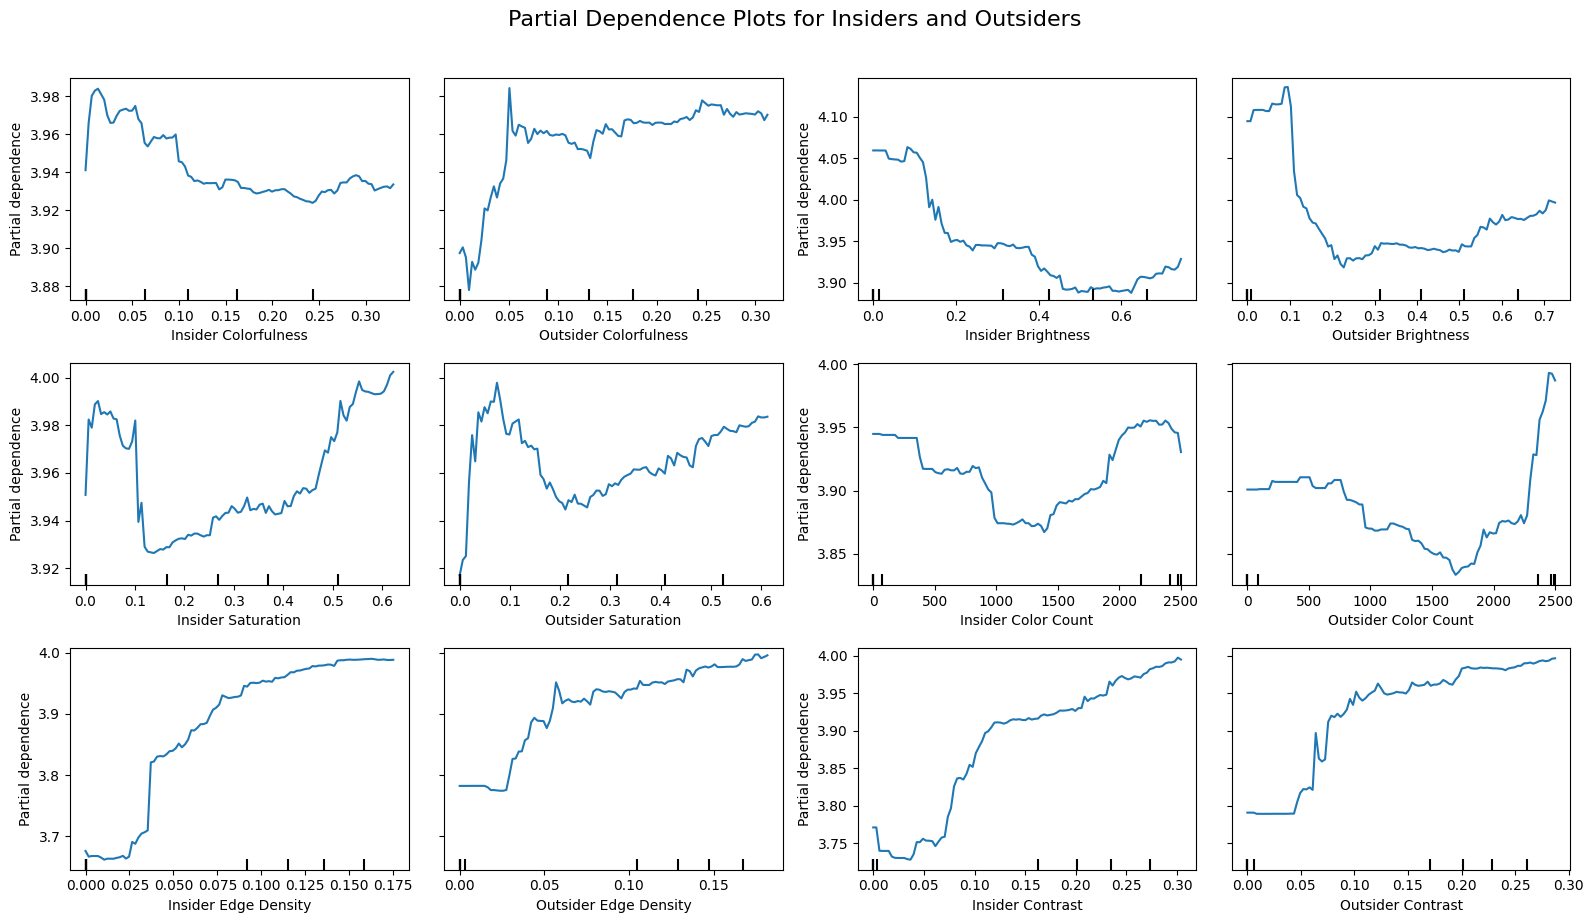

In [38]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import numpy as np

# Define the features to plot and their interactions
features = [
    ('colorfulness_x_is_insider', 'colorfulness_x_is_outsider'),
    ('brightness_x_is_insider', 'brightness_x_is_outsider'),
    ('saturation_x_is_insider', 'saturation_x_is_outsider'),
    ('color_count_x_is_insider', 'color_count_x_is_outsider'),
    ('edge_density_x_is_insider', 'edge_density_x_is_outsider'),
    ('contrast_x_is_insider', 'contrast_x_is_outsider'),
]

# Define a mapping for renaming feature names
feature_name_map = {
    'colorfulness_x_is_insider': 'Insider Colorfulness',
    'colorfulness_x_is_outsider': 'Outsider Colorfulness',
    'brightness_x_is_insider': 'Insider Brightness',
    'brightness_x_is_outsider': 'Outsider Brightness',
    'saturation_x_is_insider': 'Insider Saturation',
    'saturation_x_is_outsider': 'Outsider Saturation',
    'color_count_x_is_insider': 'Insider Color Count',
    'color_count_x_is_outsider': 'Outsider Color Count',
    'edge_density_x_is_insider': 'Insider Edge Density',
    'edge_density_x_is_outsider': 'Outsider Edge Density',
    'contrast_x_is_insider': 'Insider Contrast',
    'contrast_x_is_outsider': 'Outsider Contrast',
}

# Set number of columns per row
n_cols = 2
n_rows = int(np.ceil(len(features) / n_cols))  # Calculate required rows

# Initialize variables to track min and max y values
min_y, max_y = np.inf, -np.inf

# First pass: Determine global min and max y-axis limits
for feature_pair in features:
    fig, ax = plt.subplots()  # Create a temporary figure for consistent scaling
    pdp = PartialDependenceDisplay.from_estimator(rf_combined, X, feature_pair, ax=ax)
    for single_ax in pdp.axes_.flatten():  # Iterate over all axes in the plot
        ylim = single_ax.get_ylim()
        min_y = min(min_y, ylim[0])
        max_y = max(max_y, ylim[1])
    plt.close(fig)  # Close temporary plots

# Second pass: Plot with consistent y-axis limits in a grid layout
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3 * n_rows))

# Flatten axes array for easier indexing if needed
axes = axes.flatten()

for i, (ax, feature_pair) in enumerate(zip(axes, features)):
    # Create PDP for the pair of features
    pdp = PartialDependenceDisplay.from_estimator(
        rf_combined, X, feature_pair, ax=ax
    )
    
    # Update x-axis labels with user-friendly names
    x_labels = [feature_name_map[feature] for feature in feature_pair]
    pdp.axes_[0, 0].set_xlabel(x_labels[0])
    pdp.axes_[0, 1].set_xlabel(x_labels[1])
    
    # Ensure consistent y-axis scaling
    ax.set_ylim(min_y, max_y)

# Remove empty subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a general title to the figure
plt.suptitle('Partial Dependence Plots for Insiders and Outsiders', fontsize=16, y=1.02)

plt.tight_layout()
plt.show()


#### Romance

In [39]:
# Create interaction terms for features
for col in ['brightness', 'saturation', 'color_count', 'colorfulness', 'contrast', 'edge_density', 'num_objects', 'is_person', 'is_bird', 'is_clock','is_dog', 'is_cup', 'is_tie',
       'is_cat', 'is_tv']:
    romance_df[f"{col}_x_is_insider"] = romance_df[col] * romance_df['is_insider']

# Create interaction terms for features
for col in ['brightness', 'saturation', 'color_count', 'colorfulness', 'contrast', 'edge_density', 'num_objects', 'is_person', 'is_bird', 'is_clock','is_dog', 'is_cup', 'is_tie',
       'is_cat', 'is_tv']:
    romance_df[f"{col}_x_is_outsider"] = romance_df[col] * romance_df['is_outsider']

# Define the feature set (including interaction terms) and target variable
X = romance_df[['brightness_x_is_insider', 'saturation_x_is_insider', 'color_count_x_is_insider', 'colorfulness_x_is_insider', 'contrast_x_is_insider', 'edge_density_x_is_insider', 'num_objects_x_is_insider', 'is_person_x_is_insider', 'is_bird_x_is_insider', 'is_clock_x_is_insider','is_dog_x_is_insider', 'is_cup_x_is_insider', 'is_tie_x_is_insider',
         'is_cat_x_is_insider', 'is_tv_x_is_insider',
                    'brightness_x_is_outsider', 'saturation_x_is_outsider', 'color_count_x_is_outsider', 'colorfulness_x_is_outsider', 'contrast_x_is_outsider', 'edge_density_x_is_outsider', 'num_objects_x_is_outsider', 'is_person_x_is_outsider', 'is_bird_x_is_outsider', 'is_clock_x_is_outsider','is_dog_x_is_outsider', 'is_cup_x_is_outsider', 'is_tie_x_is_outsider',
            'is_cat_x_is_outsider', 'is_tv_x_is_outsider']]
y = romance_df['log_ratings_count']

# Train a Random Forest with the best hyperparameters
rf_combined = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42
)

# Fit the model
rf_combined.fit(X, y)

# Predictions
y_pred = rf_combined.predict(X)

# Evaluation metrics
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print(f"R-squared: {r2:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")


R-squared: 0.093
Mean Absolute Error: 1.391


In [40]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
perm_importance = permutation_importance(rf_combined, X, y, n_repeats=30, random_state=42)

# Display importance and p-values
for feature, importance, pval in zip(X.columns, perm_importance.importances_mean, perm_importance.importances_std):
    print(f"Feature: {feature}, Importance: {importance:.4f}, Std Dev: {pval:.4f}")

Feature: brightness_x_is_insider, Importance: 0.0198, Std Dev: 0.0004
Feature: saturation_x_is_insider, Importance: 0.0199, Std Dev: 0.0006
Feature: color_count_x_is_insider, Importance: 0.0286, Std Dev: 0.0010
Feature: colorfulness_x_is_insider, Importance: 0.0190, Std Dev: 0.0006
Feature: contrast_x_is_insider, Importance: 0.0233, Std Dev: 0.0007
Feature: edge_density_x_is_insider, Importance: 0.0190, Std Dev: 0.0004
Feature: num_objects_x_is_insider, Importance: 0.0096, Std Dev: 0.0004
Feature: is_person_x_is_insider, Importance: 0.0070, Std Dev: 0.0002
Feature: is_bird_x_is_insider, Importance: 0.0000, Std Dev: 0.0000
Feature: is_clock_x_is_insider, Importance: 0.0000, Std Dev: 0.0000
Feature: is_dog_x_is_insider, Importance: 0.0022, Std Dev: 0.0002
Feature: is_cup_x_is_insider, Importance: 0.0006, Std Dev: 0.0001
Feature: is_tie_x_is_insider, Importance: 0.0014, Std Dev: 0.0001
Feature: is_cat_x_is_insider, Importance: 0.0000, Std Dev: 0.0000
Feature: is_tv_x_is_insider, Importanc

In [41]:
from sklearn.inspection import permutation_importance
from scipy.stats import ttest_rel, wilcoxon
import pandas as pd

# Fit your model (e.g., Random Forest or Gradient Boosting)
rf_combined.fit(X, y)

# Compute permutation importance for all features
perm_importance = permutation_importance(rf_combined, X, y, n_repeats=30, random_state=42)

# Extract importance values for each feature
importance_dict = {feature: perm_importance.importances[i] for i, feature in enumerate(X.columns)}

# Convert to a DataFrame for easier manipulation
importance_df = pd.DataFrame(importance_dict)

# Example: Compare interaction terms for insider vs outsider
results = []
for feature in ['brightness', 'saturation', 'color_count', 'colorfulness', 'contrast', 'edge_density', 'num_objects', 'is_person', 'is_bird', 'is_clock', 'is_dog', 'is_cup', 'is_tie',
       'is_cat', 'is_tv']:
    insider_feature = f"{feature}_x_is_insider"
    outsider_feature = f"{feature}_x_is_outsider"

    if insider_feature in importance_df.columns and outsider_feature in importance_df.columns:
        # Extract distributions
        insider_importances = importance_df[insider_feature]
        outsider_importances = importance_df[outsider_feature]

        # Perform paired t-test
        t_stat, p_value_ttest = ttest_rel(insider_importances, outsider_importances)

        # Perform Wilcoxon signed-rank test (non-parametric alternative)
        try:
            w_stat, p_value_wilcoxon = wilcoxon(insider_importances, outsider_importances, zero_method="zsplit")
        except ValueError:
            w_stat, p_value_wilcoxon = None, None  # Handle case with all-zero differences

        # Store the results
        results.append({
            'Feature': feature,
            'Insider Interaction': insider_feature,
            'Outsider Interaction': outsider_feature,
            'Mean_Insider': insider_importances.mean(),
            'Mean_Outsider': outsider_importances.mean(),
            'T-Stat': t_stat,
            'P-Value (t-test)': p_value_ttest,
            'W-Stat': w_stat,
            'P-Value (Wilcoxon)': p_value_wilcoxon
        })

# Convert results to a DataFrame for display
results_df = pd.DataFrame(results)

In [42]:
# Function to clean and transform feature names
def clean_feature_name(feature_name):
    if feature_name == "edge_density":
        return "Edge density"
    elif feature_name == "num_objects":
        return "Number of Objects"
    elif "is_" in feature_name:  # Remove 'is_' and capitalize
        return feature_name.replace("is_", "").capitalize()
    else:
        return feature_name.capitalize()

# Apply the transformations to 'Feature', 'Insider Interaction', and 'Outsider Interaction'
results_df['Feature'] = results_df['Feature'].apply(clean_feature_name)

# Drop the Insider and Outsider Interaction columns
results_df.drop(columns=['Insider Interaction', 'Outsider Interaction'], inplace=True)

# Rename the columns 'Mean_Insider' and 'Mean_Outsider'
results_df.rename(columns={
    'Mean_Insider': 'Mean Value Insider',
    'Mean_Outsider': 'Mean Value Outsider'
}, inplace=True)


In [43]:
from IPython.display import display, HTML
import pandas as pd

# Convert the DataFrame to HTML
html_table = results_df.to_html(index=False)

# Define custom CSS to style the table
custom_css = """
<style>
/* Apply Times New Roman to the table */
table {
    font-family: 'Times New Roman', Times, serif;
    font-size: 14px; /* Adjust font size */
    width: 100%;
    border-collapse: collapse;
    text-align: center;
}

/* Style table headers */
table th {
    background-color: #f2f2f2; /* Header background color */
    border: 1px solid #ddd; /* Header border */
    padding: 8px; /* Header padding */
}

/* Style table data */
table td {
    border: 1px solid #ddd; /* Data border */
    padding: 8px; /* Data padding */
}
</style>
"""

# Combine the CSS and HTML table
styled_table = f"{custom_css}\n{html_table}"

# Save the styled table to an HTML file
output_file = "styled_table.html"
with open(output_file, "w") as file:
    file.write(styled_table)

# Display the styled table
display(HTML(styled_table))


Feature,Mean Value Insider,Mean Value Outsider,T-Stat,P-Value (t-test),W-Stat,P-Value (Wilcoxon)
Brightness,0.019848,0.015888,37.249671,4.821241e-26,0.0,1.862645e-09
Saturation,0.019870,0.015115,38.518717,1.859166e-26,0.0,1.862645e-09
Color_count,0.028600,0.023539,24.001702,1.110268e-20,0.0,1.862645e-09
Colorfulness,0.018974,0.019340,-2.341061,2.631260e-02,127.0,2.932586e-02
Contrast,0.023286,0.018623,39.640247,8.210465e-27,0.0,1.862645e-09
Edge density,0.018971,0.018614,2.875979,7.475011e-03,105.0,7.612137e-03
Number of Objects,0.009605,0.006591,37.766375,3.258723e-26,0.0,1.862645e-09
Person,0.007007,0.005253,34.323150,4.915184e-25,0.0,1.862645e-09
Bird,0.000000,0.000000,NaN,NaN,232.5,1.000000e+00
Clock,0.000000,0.000000,NaN,NaN,232.5,1.000000e+00


In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

for feature in ['average_brightness', 'average_saturation', 'color_count', 'colorfulness', 'contrast', 'edge_density']:
    interaction_feature = f"{feature}_x_special_feature"

    if interaction_feature in importance_df.columns:
        plt.figure(figsize=(8, 6))
        sns.kdeplot(importance_df[feature], label=feature, shade=True)
        sns.kdeplot(importance_df[interaction_feature], label=interaction_feature, shade=True)
        plt.title(f'Permutation Importances: {feature} vs {interaction_feature}')
        plt.xlabel('Importance')
        plt.ylabel('Density')
        plt.legend()
        plt.show()


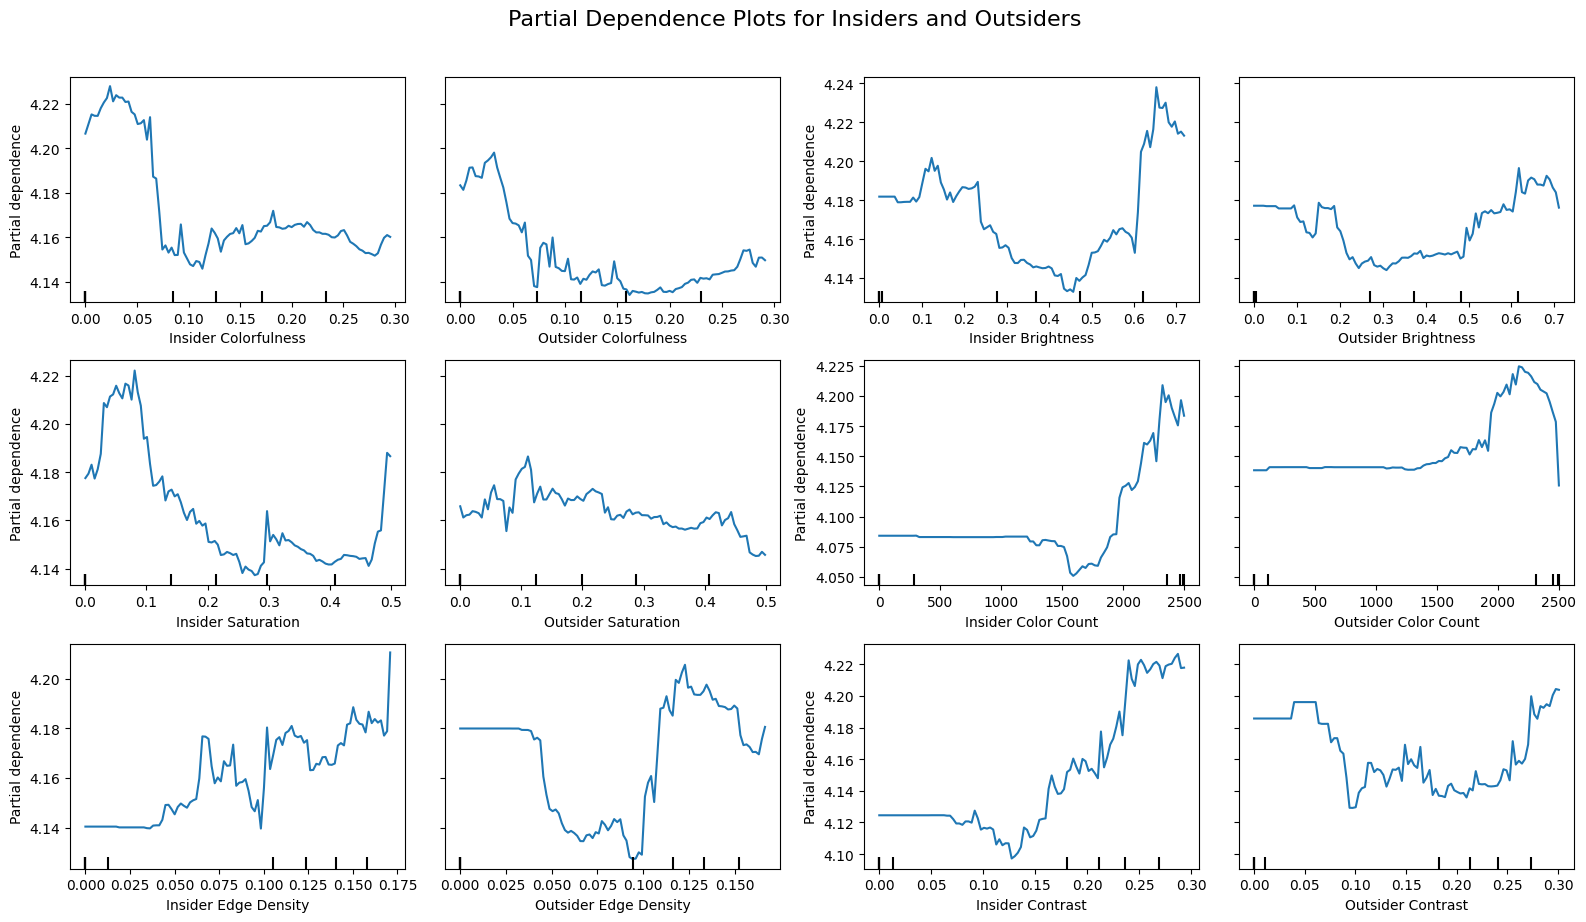

In [45]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import numpy as np

# Define the features to plot and their interactions
features = [
    ('colorfulness_x_is_insider', 'colorfulness_x_is_outsider'),
    ('brightness_x_is_insider', 'brightness_x_is_outsider'),
    ('saturation_x_is_insider', 'saturation_x_is_outsider'),
    ('color_count_x_is_insider', 'color_count_x_is_outsider'),
    ('edge_density_x_is_insider', 'edge_density_x_is_outsider'),
    ('contrast_x_is_insider', 'contrast_x_is_outsider'),
]

# Define a mapping for renaming feature names
feature_name_map = {
    'colorfulness_x_is_insider': 'Insider Colorfulness',
    'colorfulness_x_is_outsider': 'Outsider Colorfulness',
    'brightness_x_is_insider': 'Insider Brightness',
    'brightness_x_is_outsider': 'Outsider Brightness',
    'saturation_x_is_insider': 'Insider Saturation',
    'saturation_x_is_outsider': 'Outsider Saturation',
    'color_count_x_is_insider': 'Insider Color Count',
    'color_count_x_is_outsider': 'Outsider Color Count',
    'edge_density_x_is_insider': 'Insider Edge Density',
    'edge_density_x_is_outsider': 'Outsider Edge Density',
    'contrast_x_is_insider': 'Insider Contrast',
    'contrast_x_is_outsider': 'Outsider Contrast',
}

# Set number of columns per row
n_cols = 2
n_rows = int(np.ceil(len(features) / n_cols))  # Calculate required rows

# Initialize variables to track min and max y values
min_y, max_y = np.inf, -np.inf

# First pass: Determine global min and max y-axis limits
for feature_pair in features:
    fig, ax = plt.subplots()  # Create a temporary figure for consistent scaling
    pdp = PartialDependenceDisplay.from_estimator(rf_combined, X, feature_pair, ax=ax)
    for single_ax in pdp.axes_.flatten():  # Iterate over all axes in the plot
        ylim = single_ax.get_ylim()
        min_y = min(min_y, ylim[0])
        max_y = max(max_y, ylim[1])
    plt.close(fig)  # Close temporary plots

# Second pass: Plot with consistent y-axis limits in a grid layout
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3 * n_rows))

# Flatten axes array for easier indexing if needed
axes = axes.flatten()

for i, (ax, feature_pair) in enumerate(zip(axes, features)):
    # Create PDP for the pair of features
    pdp = PartialDependenceDisplay.from_estimator(
        rf_combined, X, feature_pair, ax=ax
    )
    
    # Update x-axis labels with user-friendly names
    x_labels = [feature_name_map[feature] for feature in feature_pair]
    pdp.axes_[0, 0].set_xlabel(x_labels[0])
    pdp.axes_[0, 1].set_xlabel(x_labels[1])
    
    # Ensure consistent y-axis scaling
    ax.set_ylim(min_y, max_y)

# Remove empty subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a general title to the figure
plt.suptitle('Partial Dependence Plots for Insiders and Outsiders', fontsize=16, y=1.02)

plt.tight_layout()
plt.show()


In [46]:
romance_df[['image_url']]

,image_url
35616,https://images.gr-assets.com/books/1380049719m...
35617,https://images.gr-assets.com/books/1444389845m...
35628,https://images.gr-assets.com/books/1427199955m...
35631,https://images.gr-assets.com/books/1404962812m...
35641,https://images.gr-assets.com/books/1441048707m...
...,...
119030,https://images.gr-assets.com/books/1481745522m...
119041,https://images.gr-assets.com/books/1458179767m...
119042,https://images.gr-assets.com/books/1370968087m...
119043,https://images.gr-assets.com/books/1472115799m...


In [47]:
import pandas as pd

# Adjust the column width to prevent truncation
pd.set_option('display.max_colwidth', None)

# Print 100 random rows
print(romance_df[['image_url']].sample(n=100, random_state=40)) 

                                                          image_url
93099   https://images.gr-assets.com/books/1361410961m/17404967.jpg
114263  https://images.gr-assets.com/books/1448381148m/27917161.jpg
63044   https://images.gr-assets.com/books/1448226439m/27878923.jpg
87341   https://images.gr-assets.com/books/1326994523m/13418165.jpg
59069   https://images.gr-assets.com/books/1405041285m/22707241.jpg
...                                                             ...
68944   https://images.gr-assets.com/books/1442841782m/25365496.jpg
67833   https://images.gr-assets.com/books/1383660576m/18586274.jpg
39906   https://images.gr-assets.com/books/1443098041m/26808358.jpg
69366   https://images.gr-assets.com/books/1337649821m/14127495.jpg
94750   https://images.gr-assets.com/books/1469752237m/31286570.jpg

[100 rows x 1 columns]


In [48]:
emily = romance_df[romance_df['image_url'] == 'https://images.gr-assets.com/books/1448226439m/27878923.jpg']

In [49]:
emily[['brightness', 'saturation', 'color_count', 'colorfulness', 'contrast', 'edge_density', 'num_objects', 'is_person', 'is_bird', 'is_clock', 'is_dog', 'is_cup', 'is_tie',
       'is_cat', 'is_tv']]

,brightness,saturation,color_count,colorfulness,contrast,edge_density,num_objects,is_person,is_bird,is_clock,is_dog,is_cup,is_tie,is_cat,is_tv
63044,0.327478,0.313731,2475.0,0.155092,0.258056,0.173589,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0


In [50]:
emily = romance_df[romance_df['image_url'] == 'https://images.gr-assets.com/books/1456101639m/29240260.jpg']

In [51]:
emily[['brightness', 'saturation', 'color_count', 'colorfulness', 'contrast', 'edge_density', 'num_objects', 'is_person', 'is_bird', 'is_clock', 'is_dog', 'is_cup', 'is_tie',
       'is_cat', 'is_tv']]

,brightness,saturation,color_count,colorfulness,contrast,edge_density,num_objects,is_person,is_bird,is_clock,is_dog,is_cup,is_tie,is_cat,is_tv
108400,0.242304,0.233067,2495.0,0.099485,0.228455,0.150969,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0
